In [35]:
#IMPORT LIBRARIES
import pandas as pd
import numpy as np
import seaborn as sns
import os
import re
import nltk
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from wordcloud import WordCloud
from nltk.util import pr
stemmer = nltk.SnowballStemmer("english")
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import string
stop_words = set(stopwords.words("english"))
!pip install textblob
import textblob           
from textblob import TextBlob

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Usamah\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Usamah\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Usamah\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [36]:
#IMPORT DATA SET 
#df = pd.read_csv("labeled_data.csv")
df = pd.read_csv("C:/Users/Usamah/Downloads/archive (2)/labeled_data.csv")
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [37]:
#DATA SHAPE
print(f"num of tweets: {df.shape}")

# extract the text and labels
tweet = list(df['tweet'])
labels = list(df['class'])

num of tweets: (24783, 7)


In [38]:
#TEXT CLEANING 

# add rt to remove retweet in dataset (noise)
stop_words.add("rt")

# remove html entity:
def remove_entity(raw_text):
    entity_regex = r"&[^\s;]+;"
    text = re.sub(entity_regex, "", raw_text)
    return text

# change the user tags
def change_user(raw_text):
    regex = r"@([^ ]+)"
    text = re.sub(regex, "user", raw_text)

    return text

# remove urls
def remove_url(raw_text):
    url_regex = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
    text = re.sub(url_regex, '', raw_text)

    return text

# remove unnecessary symbols
def remove_noise_symbols(raw_text):
    text = raw_text.replace('"', '')
    text = text.replace("'", '')
    text = text.replace("!", '')
    text = text.replace("`", '')
    text = text.replace("..", '')
    
    return text

# remove stopwords
def remove_stopwords(raw_text):
    tokenize = nltk.word_tokenize(raw_text)
    text = [word for word in tokenize if not word.lower() in stop_words]
    text = " ".join(text)

    return text

# this function in to clean all the dataset by utilizing all the function above
def preprocess(datas):
    clean = []
    # change the @xxx into "user"
    clean = [change_user(text) for text in datas]
    # remove emojis (specifically unicode emojis)
    clean = [remove_entity(text) for text in clean]
    # remove urls
    clean = [remove_url(text) for text in clean]
    # remove trailing stuff
    clean = [remove_noise_symbols(text) for text in clean]
    # remove stopwords
    clean = [remove_stopwords(text) for text in clean]

    return clean

In [39]:
# call the cleaning function
df['tweet'] = preprocess(tweet)

In [40]:
#DROP DUPLICATES
df = df.drop_duplicates('tweet')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24330 entries, 0 to 24782
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          24330 non-null  int64 
 1   count               24330 non-null  int64 
 2   hate_speech         24330 non-null  int64 
 3   offensive_language  24330 non-null  int64 
 4   neither             24330 non-null  int64 
 5   class               24330 non-null  int64 
 6   tweet               24330 non-null  object
dtypes: int64(6), object(1)
memory usage: 1.5+ MB


In [41]:
#CLASSIFY DATA
df['labels'] = df['class'].map({0:"Hate Speech Detected", 1:"Offensive Language Detected", 2:"No hate and Offensive speech"})
df = df[['tweet', 'labels']]
df.head()

,tweet,labels
0,user woman shouldnt complain cleaning house . ...,No hate and Offensive speech
1,user boy dats cold.tyga dwn bad cuffin dat hoe...,Offensive Language Detected
2,user Dawg user ever fuck bitch start cry ? con...,Offensive Language Detected
3,user user look like tranny,Offensive Language Detected
4,user shit hear might true might faker bitch to...,Offensive Language Detected


In [42]:
#Value counts
df['labels'].value_counts()

labels
Offensive Language Detected     18834
No hate and Offensive speech     4093
Hate Speech Detected             1403
Name: count, dtype: int64

In [43]:
#Cleaned data
df.head()

,tweet,labels
0,user woman shouldnt complain cleaning house . ...,No hate and Offensive speech
1,user boy dats cold.tyga dwn bad cuffin dat hoe...,Offensive Language Detected
2,user Dawg user ever fuck bitch start cry ? con...,Offensive Language Detected
3,user user look like tranny,Offensive Language Detected
4,user shit hear might true might faker bitch to...,Offensive Language Detected


<Axes: xlabel='labels', ylabel='count'>

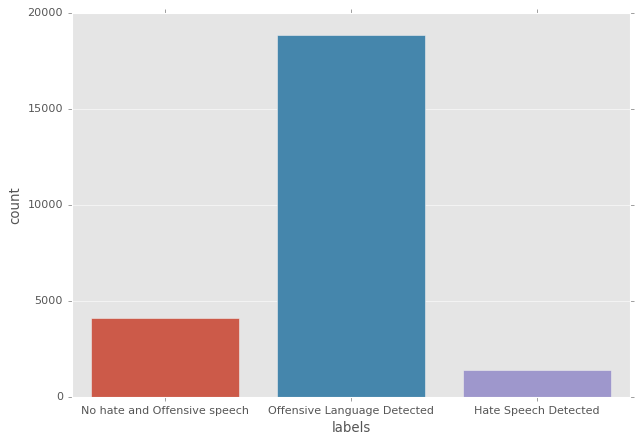

In [44]:
#DATA VISUALIZATION
fig = plt.figure(figsize = (9,6))
sns.countplot(x='labels', data = df)

In [45]:
#DATA PREPROCESSING
#TOKENIZATION
def tokenization(text):
   text = re.split('\W+', text)
   return text

df['tweet'] = df['tweet'].apply(lambda x: tokenization(x.lower()))
df.head()

,tweet,labels
0,"[user, woman, shouldnt, complain, cleaning, ho...",No hate and Offensive speech
1,"[user, boy, dats, cold, tyga, dwn, bad, cuffin...",Offensive Language Detected
2,"[user, dawg, user, ever, fuck, bitch, start, c...",Offensive Language Detected
3,"[user, user, look, like, tranny]",Offensive Language Detected
4,"[user, shit, hear, might, true, might, faker, ...",Offensive Language Detected


In [46]:
#FEATURE_EXTRACTION USING TFIDF
X = df['tweet'].tolist()
X = [" ".join(doc) for doc in X]

y = np.array(df["labels"])
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(X)

In [50]:
X

<24330x21187 sparse matrix of type '<class 'numpy.float64'>'
	with 196229 stored elements in Compressed Sparse Row format>

In [13]:
#SPLIT THE DATA 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
#TRAIN THE MODEL
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [15]:
#TEST ACCURACY
clf_predict = clf.predict(X_test)
clf_acc = accuracy_score(clf_predict, y_test)
print("Test accuracy: {:.2f}%".format(clf_acc*100))

Test accuracy: 88.92%


In [16]:
#CONFUSION MATRIX AND CLASSIFICATION REPORT
print(confusion_matrix(y_test, clf_predict))
print("/n")
print(classification_report(y_test, clf_predict))

[[  67   36  167]
 [  15  727   90]
 [ 115  116 3533]]
/n
                              precision    recall  f1-score   support

        Hate Speech Detected       0.34      0.25      0.29       270
No hate and Offensive speech       0.83      0.87      0.85       832
 Offensive Language Detected       0.93      0.94      0.94      3764

                    accuracy                           0.89      4866
                   macro avg       0.70      0.69      0.69      4866
                weighted avg       0.88      0.89      0.88      4866



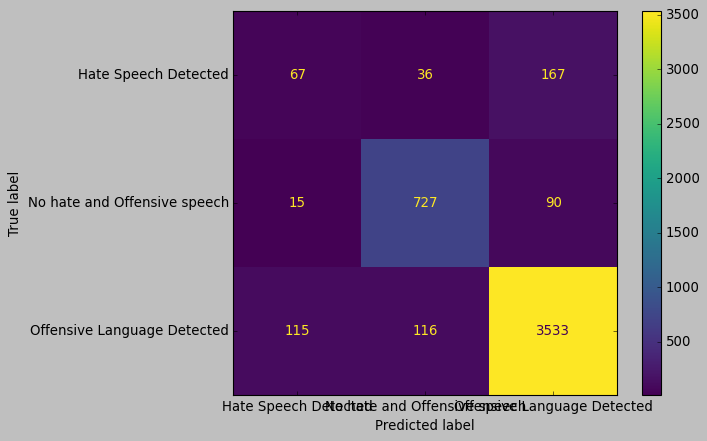

In [17]:
#VISUALIZE CONFUSION MATRIX
style.use('classic')
cm = confusion_matrix(y_test, clf_predict, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

In [18]:
#HYPERPARAMETER TUNING
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid = GridSearchCV(DecisionTreeClassifier(), param_grid, cv = 5)
grid.fit(X_train, y_train)
print("Best Cross Validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

Best Cross Validation score: 0.88
Best parameters:  {'criterion': 'gini', 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [19]:
y_pred = grid.predict(X_test)

In [20]:
#NEW TEST ACCURACY
clf_acc = accuracy_score(y_pred, y_test)
print("Test accuracy: {:.2f}%".format(clf_acc*100))

Test accuracy: 89.46%


In [21]:
#NEW CONFUSION MATRIX AND CLASSIFICATION REPORT
print(confusion_matrix(y_test, y_pred))
print("/n")
print(classification_report(y_test, y_pred))

[[  73   54  143]
 [   2  809   21]
 [ 104  189 3471]]
/n
                              precision    recall  f1-score   support

        Hate Speech Detected       0.41      0.27      0.33       270
No hate and Offensive speech       0.77      0.97      0.86       832
 Offensive Language Detected       0.95      0.92      0.94      3764

                    accuracy                           0.89      4866
                   macro avg       0.71      0.72      0.71      4866
                weighted avg       0.89      0.89      0.89      4866



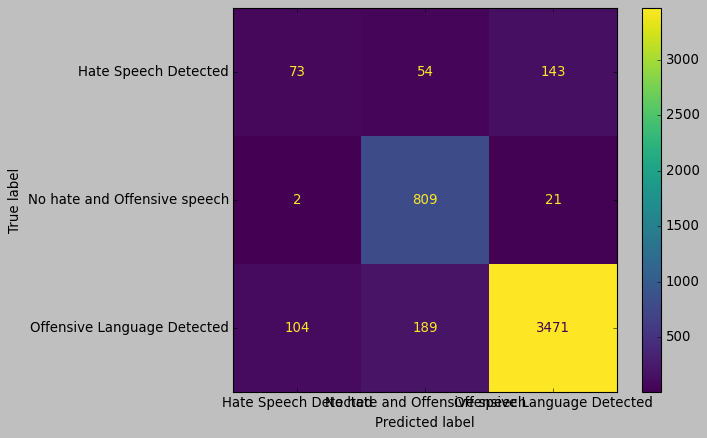

In [23]:
#VISUALIZE CONFUSION MATRIX
style.use('classic')
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

In [34]:
#TEST THE MODEL
test_data = " ever fuck bitch start cry"
df = vectorizer.transform([test_data]).toarray()
print(clf.predict(df))

['Offensive Language Detected']
